In [78]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import requests
from bs4 import BeautifulSoup

from bullpen import data_utils

In [ ]:
# TODO: how to handle multiple teams in supplemental data....

In [19]:
df = pd.read_csv("../data/k.csv")
df

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%
0,695243,31757,Mason Miller,OAK,25,2024,249,0.417671
1,621242,14710,Edwin Díaz,NYM,30,2024,216,0.388889
2,518585,7048,Fernando Cruz,CIN,34,2024,288,0.378472
3,623352,14212,Josh Hader,HOU,30,2024,278,0.377698
4,663574,19926,Tony Santillan,CIN,27,2024,122,0.377049
...,...,...,...,...,...,...,...,...
1887,592346,14663,Chi Chi González,COL,29,2021,448,0.125000
1888,642092,19826,Riley Smith,ARI,26,2021,301,0.119601
1889,677976,23798,Randy Dobnak,MIN,26,2021,228,0.118421
1890,433589,4020,Yusmeiro Petit,OAK,36,2021,313,0.118211


In [22]:
df[df.Team.str.startswith("-")]

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%
17,643410,15551,Mark Leiter Jr.,- - -,33,2024,256,0.335938
32,554340,12095,Yimi García,- - -,33,2024,153,0.320261
36,656629,17282,Michael Kopech,- - -,28,2024,279,0.315412
46,640462,19343,A.J. Puk,- - -,29,2024,294,0.299320
47,656427,17479,Jack Flaherty,- - -,28,2024,649,0.298921
...,...,...,...,...,...,...,...,...
1845,593144,13549,Richard Rodríguez,- - -,31,2021,251,0.167331
1864,623485,15139,Ashton Goudeau,- - -,28,2021,141,0.156028
1873,452657,4930,Jon Lester,- - -,37,2021,627,0.145136
1876,669060,19990,Bryse Wilson,- - -,23,2021,322,0.142857


In [5]:
provided_data, supplemental_data = data_utils.load_data(
    provided_path=data_utils.DATA_DIR.joinpath("k.csv"),
    supplemental_path=data_utils.DATA_DIR.joinpath("supplemental-stats.csv"),
)

In [6]:
provided_data.head()

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%
0,695243,31757,Mason Miller,OAK,25,2024,249,0.417671
1,621242,14710,Edwin Díaz,NYM,30,2024,216,0.388889
2,518585,7048,Fernando Cruz,CIN,34,2024,288,0.378472
3,623352,14212,Josh Hader,HOU,30,2024,278,0.377698
4,663574,19926,Tony Santillan,CIN,27,2024,122,0.377049


In [83]:
provided_data[provided_data.Name == "A.J. Puk"].to_dict()

{'MLBAMID': {46: 640462, 498: 640462, 1057: 640462},
 'PlayerId': {46: 19343, 498: 19343, 1057: 19343},
 'Name': {46: 'A.J. Puk', 498: 'A.J. Puk', 1057: 'A.J. Puk'},
 'Team': {46: '- - -', 498: 'MIA', 1057: 'OAK'},
 'Age': {46: 29, 498: 28, 1057: 27},
 'Season': {46: 2024, 498: 2023, 1057: 2022},
 'TBF': {46: 294, 498: 242, 1057: 281},
 'K%': {46: 0.29931973, 498: 0.32231405, 1057: 0.27046263}}

In [85]:
mock_data = {
    "MLBAMID": {46: 640462, 498: 640462, 1057: 640462},
    "PlayerId": {46: 19343, 498: 19343, 1057: 19343},
    "Name": {46: "A.J. Puk", 498: "A.J. Puk", 1057: "A.J. Puk"},
    "Team": {46: "- - -", 498: "MIA", 1057: "OAK"},
    "Age": {46: 29, 498: 28, 1057: 27},
    "Season": {46: 2024, 498: 2023, 1057: 2022},
    "TBF": {46: 294, 498: 242, 1057: 281},
    "K%": {46: 0.29931973, 498: 0.32231405, 1057: 0.27046263},
}

pd.DataFrame(mock_data)

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%
46,640462,19343,A.J. Puk,- - -,29,2024,294,0.299320
498,640462,19343,A.J. Puk,MIA,28,2023,242,0.322314
1057,640462,19343,A.J. Puk,OAK,27,2022,281,0.270463


In [87]:
supplemental_data[supplemental_data.Name == "A.J. Puk"].to_dict()

{'Rk': {819: 820, 1931: 773, 2994: 755, 4085: 782, 4086: 783, 4087: 784},
 'Name': {819: 'A.J. Puk',
  1931: 'A.J. Puk',
  2994: 'A.J. Puk',
  4085: 'A.J. Puk',
  4086: 'A.J. Puk',
  4087: 'A.J. Puk'},
 'Age': {819: 26, 1931: 27, 2994: 28, 4085: 29, 4086: 29, 4087: 29},
 'Tm': {819: 'OAK',
  1931: 'OAK',
  2994: 'MIA',
  4085: 'TOT',
  4086: 'MIA',
  4087: 'ARI'},
 'IP': {819: 13.1, 1931: 66.1, 2994: 56.2, 4085: 71.1, 4086: 44.0, 4087: 27.1},
 'PA': {819: 65, 1931: 281, 2994: 242, 4085: 294, 4086: 191, 4087: 103},
 'Pit': {819: 243, 1931: 1072, 2994: 950, 4085: 1173, 4086: 756, 4087: 417},
 'Pit/PA': {819: 3.74,
  1931: 3.81,
  2994: 3.93,
  4085: 3.99,
  4086: 3.96,
  4087: 4.05},
 'Str': {819: 151, 1931: 702, 2994: 650, 4085: 781, 4086: 486, 4087: 295},
 'Str%': {819: 0.621,
  1931: 0.655,
  2994: 0.684,
  4085: 0.6659999999999999,
  4086: 0.643,
  4087: 0.7070000000000001},
 'L/Str': {819: '28.5%',
  1931: '27.4%',
  2994: '29.5%',
  4085: '26.0%',
  4086: '26.3%',
  4087: '25.4%'},

In [88]:
pd.DataFrame(_)

,Rk,Name,Age,Tm,IP,PA,Pit,Pit/PA,Str,Str%,...,02h,L/SO,S/SO,L/SO%,3pK,4pW,PAu,Pitu,Stru,Season
819,820,A.J. Puk,26,OAK,13.1,65,243,3.74,151,0.621,...,1,4,12,0.250,3,0,0,0,0,2021
1931,773,A.J. Puk,27,OAK,66.1,281,1072,3.81,702,0.655,...,6,22,54,0.289,15,4,0,0,0,2022
2994,755,A.J. Puk,28,MIA,56.2,242,950,3.93,650,0.684,...,6,22,56,0.282,16,0,0,0,0,2023
4085,782,A.J. Puk,29,TOT,71.1,294,1173,3.99,781,0.666,...,4,13,75,0.148,22,0,0,0,0,2024
4086,783,A.J. Puk,29,MIA,44.0,191,756,3.96,486,0.643,...,2,5,40,0.111,12,0,0,0,0,2024
4087,784,A.J. Puk,29,ARI,27.1,103,417,4.05,295,0.707,...,2,8,35,0.186,10,0,0,0,0,2024


In [10]:
provided_data.shape

(1892, 8)

In [8]:
supplemental_data.head()

,Rk,Name,Age,Tm,IP,PA,Pit,Pit/PA,Str,Str%,...,02h,L/SO,S/SO,L/SO%,3pK,4pW,PAu,Pitu,Stru,Season
0,1,Fernando Abad,35,BAL,17.2,82,299,3.65,183,0.612,...,1,5,5,0.500,1,0,0,0,0,2021
1,2,Cory Abbott,25,CHC,17.1,82,352,4.29,203,0.577,...,0,4,8,0.333,1,2,0,0,0,2021
2,3,Albert Abreu,25,NYY,36.2,156,642,4.12,392,0.611,...,1,9,26,0.257,7,2,0,0,0,2021
3,4,Bryan Abreu,24,HOU,36.0,161,689,4.28,407,0.591,...,3,6,30,0.167,6,4,0,0,0,2021
4,5,Domingo Acevedo,27,OAK,11.0,44,174,3.95,114,0.655,...,1,0,9,0.000,4,1,0,0,0,2021


In [28]:
merged = provided_data.merge(
    supplemental_data, on=["Name", "Season", "Age"], how="left"
).sort_values(["Name", "Season", "Team"])
merged.head()

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%,Rk,Tm,...,02s,02h,L/SO,S/SO,L/SO%,3pK,4pW,PAu,Pitu,Stru
2033,621345,18655,A.J. Minter,ATL,27,2021,221,0.257919,696,ATL,...,44,7,11,46,0.193,11,4,0,0,0
1273,621345,18655,A.J. Minter,ATL,28,2022,271,0.346863,649,ATL,...,50,2,23,71,0.245,12,0,0,0,0
678,621345,18655,A.J. Minter,ATL,29,2023,260,0.315385,647,ATL,...,40,4,13,69,0.159,8,1,0,0,0
156,621345,18655,A.J. Minter,ATL,30,2024,134,0.261194,676,ATL,...,20,1,7,28,0.200,6,3,0,0,0
1387,640462,19343,A.J. Puk,OAK,27,2022,281,0.270463,773,OAK,...,48,6,22,54,0.289,15,4,0,0,0


In [29]:
provided_data[provided_data.Name == "A.J. Puk"]

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%
46,640462,19343,A.J. Puk,- - -,29,2024,294,0.299320
498,640462,19343,A.J. Puk,MIA,28,2023,242,0.322314
1057,640462,19343,A.J. Puk,OAK,27,2022,281,0.270463


In [80]:
merged[merged.Name.str.startswith("Edwin")]

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%,Rk,Tm,...,02s,02h,L/SO,S/SO,L/SO%,3pK,4pW,PAu,Pitu,Stru
1854,621242,14710,Edwin Díaz,NYM,27,2021,257,0.346303,254,NYM,...,44,5,14,75,0.157,15,6,0,0,0
1256,621242,14710,Edwin Díaz,NYM,28,2022,235,0.502128,254,NYM,...,77,4,20,98,0.169,31,4,0,0,0
1,621242,14710,Edwin Díaz,NYM,30,2024,216,0.388889,252,NYM,...,46,4,15,69,0.179,10,9,0,0,0
9,670955,20539,Edwin Uceta,TBR,26,2024,159,0.358491,988,TBR,...,23,0,7,50,0.123,7,1,0,0,0


In [30]:
merged.columns

Index(['MLBAMID', 'PlayerId', 'Name', 'Team', 'Age', 'Season', 'TBF', 'K%',
       'Rk', 'Tm', 'IP', 'PA', 'Pit', 'Pit/PA', 'Str', 'Str%', 'L/Str',
       'S/Str', 'F/Str', 'I/Str', 'AS/Str', 'I/Bll', 'AS/Pit', 'Con', '1st%',
       '30%', '30c', '30s', '02%', '02c', '02s', '02h', 'L/SO', 'S/SO',
       'L/SO%', '3pK', '4pW', 'PAu', 'Pitu', 'Stru'],
      dtype='object')

In [51]:
index_cols = [
    "MLBAMID",
    "PlayerId",
    "Name",
    "Team",
    "Tm",
    "Age",
]

MLBAMID       int64
PlayerId      int64
Name         object
Team         object
Age           int64
Season        int64
TBF           int64
K%          float64
Rk            int64
Tm           object
IP          float64
PA            int64
Pit           int64
Pit/PA      float64
Str           int64
Str%        float64
L/Str        object
S/Str       float64
F/Str       float64
I/Str       float64
AS/Str      float64
I/Bll       float64
AS/Pit      float64
Con         float64
1st%        float64
30%         float64
30c           int64
30s           int64
02%         float64
02c           int64
02s           int64
02h           int64
L/SO          int64
S/SO          int64
L/SO%       float64
3pK           int64
4pW           int64
PAu           int64
Pitu          int64
Stru          int64
dtype: object

In [81]:
merged[(merged.Name == "A.J. Puk")].Team.unique()

array(['OAK', 'MIA', '- - -'], dtype=object)

In [62]:
# not an ideal solution but works for now....

index_cols = [
    "MLBAMID",
    "PlayerId",
    "Name",
    "Team",
    "Tm",
    "Age",
]

group_cols = [c for c in index_cols if c not in ("Tm")]

cols = [c for c in merged.set_index(index_cols).select_dtypes("number").columns]

In [63]:
tmp = merged.groupby(group_cols)[cols].mean().reset_index()

In [64]:
tmp

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%,Rk,IP,...,02s,02h,L/SO,S/SO,L/SO%,3pK,4pW,PAu,Pitu,Stru
0,425794,2233,Adam Wainwright,STL,39,2021.0,828.0,0.210145,1079.0,206.1,...,96.0,5.0,67.0,105.0,0.385,30.0,4.0,0.0,0.0,0.0
1,425794,2233,Adam Wainwright,STL,40,2022.0,803.0,0.178082,1012.0,191.2,...,111.0,22.0,62.0,81.0,0.434,26.0,8.0,0.0,0.0,0.0
2,425794,2233,Adam Wainwright,STL,41,2023.0,484.0,0.113636,990.0,101.0,...,36.0,4.0,30.0,25.0,0.545,8.0,6.0,0.0,0.0,0.0
3,425844,1943,Zack Greinke,HOU,37,2021.0,697.0,0.172166,417.0,171.0,...,51.0,4.0,34.0,85.0,0.283,13.0,6.0,0.0,0.0,0.0
4,425844,1943,Zack Greinke,KCR,38,2022.0,585.0,0.124786,396.0,137.0,...,39.0,3.0,22.0,51.0,0.301,7.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1887,702352,30226,Spencer Bivens,SFG,30,2024.0,202.0,0.183168,98.0,48.2,...,29.0,1.0,12.0,25.0,0.324,6.0,3.0,0.0,0.0,0.0
1888,800049,31900,Adam Mazur,SDP,23,2024.0,158.0,0.139241,634.0,33.2,...,15.0,3.0,6.0,16.0,0.273,4.0,3.0,0.0,0.0,0.0
1889,805673,31827,Zebby Matthews,MIN,24,2024.0,177.0,0.242938,627.0,37.2,...,21.0,5.0,9.0,34.0,0.209,5.0,1.0,0.0,0.0,0.0
1890,806185,31635,Hayden Birdsong,SFG,22,2024.0,315.0,0.279365,97.0,72.0,...,32.0,1.0,25.0,63.0,0.284,12.0,11.0,0.0,0.0,0.0


In [65]:
tmp[tmp.Name == "A.J. Puk"]

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%,Rk,IP,...,02s,02h,L/SO,S/SO,L/SO%,3pK,4pW,PAu,Pitu,Stru
902,640462,19343,A.J. Puk,- - -,29,2024.0,294.0,0.299320,783.0,47.4,...,42.0,2.666667,8.666667,50.0,0.148333,14.666667,0.0,0.0,0.0,0.0
903,640462,19343,A.J. Puk,MIA,28,2023.0,242.0,0.322314,755.0,56.2,...,42.0,6.000000,22.000000,56.0,0.282000,16.000000,0.0,0.0,0.0,0.0
904,640462,19343,A.J. Puk,OAK,27,2022.0,281.0,0.270463,773.0,66.1,...,48.0,6.000000,22.000000,54.0,0.289000,15.000000,4.0,0.0,0.0,0.0


In [77]:
supplemental_data[
    (supplemental_data.Name == "A.J. Puk") & (supplemental_data.Season.isin([2024]))
][[c for c in cols if c not in ("TBF", "K%")]].mean()

Season    2024.000000
Rk         783.000000
IP          47.400000
PA         196.000000
Pit        782.000000
Pit/PA       4.000000
Str        520.666667
Str%         0.672000
S/Str        0.244667
F/Str        0.276333
I/Str        0.219667
AS/Str       0.741000
I/Bll        0.000000
AS/Pit       0.498333
Con          0.670000
1st%         0.658333
30%          0.033667
30c          6.000000
30s          4.666667
02%          0.349000
02c         65.333333
02s         42.000000
02h          2.666667
L/SO         8.666667
S/SO        50.000000
L/SO%        0.148333
3pK         14.666667
4pW          0.000000
PAu          0.000000
Pitu         0.000000
Stru         0.000000
dtype: float64

In [32]:
supplemental_data[(supplemental_data.Name == 'A.J. Puk') & (supplemental_data.Season.isin([2022, 2023, 2024])]

,Rk,Name,Age,Tm,IP,PA,Pit,Pit/PA,Str,Str%,...,02h,L/SO,S/SO,L/SO%,3pK,4pW,PAu,Pitu,Stru,Season
1931,773,A.J. Puk,27,OAK,66.1,281,1072,3.81,702,0.655,...,6,22,54,0.289,15,4,0,0,0,2022
2994,755,A.J. Puk,28,MIA,56.2,242,950,3.93,650,0.684,...,6,22,56,0.282,16,0,0,0,0,2023
4085,782,A.J. Puk,29,TOT,71.1,294,1173,3.99,781,0.666,...,4,13,75,0.148,22,0,0,0,0,2024
4086,783,A.J. Puk,29,MIA,44.0,191,756,3.96,486,0.643,...,2,5,40,0.111,12,0,0,0,0,2024
4087,784,A.J. Puk,29,ARI,27.1,103,417,4.05,295,0.707,...,2,8,35,0.186,10,0,0,0,0,2024


In [33]:
test = df[df.Season == 2024]
test

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%
0,695243,31757,Mason Miller,OAK,25,2024,249,0.417671
1,621242,14710,Edwin Díaz,NYM,30,2024,216,0.388889
2,518585,7048,Fernando Cruz,CIN,34,2024,288,0.378472
3,623352,14212,Josh Hader,HOU,30,2024,278,0.377698
4,663574,19926,Tony Santillan,CIN,27,2024,122,0.377049
...,...,...,...,...,...,...,...,...
469,641703,16466,Brent Honeywell,- - -,29,2024,149,0.120805
470,621389,14361,Ty Blach,COL,33,2024,330,0.109091
471,657612,16814,Tim Hill,- - -,34,2024,291,0.106529
472,664350,19680,Sixto Sánchez,MIA,25,2024,162,0.104938


In [12]:
train = df[df.Season != 2024]
train

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%
474,642585,20666,Félix Bautista,BAL,28,2023,237,0.464135
475,547973,10233,Aroldis Chapman,- - -,35,2023,249,0.413655
476,594798,10954,Jacob deGrom,TEX,35,2023,115,0.391304
477,596112,13594,Robert Stephenson,- - -,30,2023,201,0.383085
478,642207,15816,Devin Williams,MIL,28,2023,231,0.376623
...,...,...,...,...,...,...,...,...
1887,592346,14663,Chi Chi González,COL,29,2021,448,0.125000
1888,642092,19826,Riley Smith,ARI,26,2021,301,0.119601
1889,677976,23798,Randy Dobnak,MIN,26,2021,228,0.118421
1890,433589,4020,Yusmeiro Petit,OAK,36,2021,313,0.118211


In [13]:
seasons = train.groupby(["PlayerId", "Name"])["Season"].apply(list)
k = train.groupby("PlayerId")["K%"].apply(list)
merged = pd.DataFrame(seasons).join(k)
merged

,,Season,K%
PlayerId,Name,,
1246,Matt Bush,[2022],[0.30327869]
1247,Adam Ottavino,"[2023, 2022, 2021]","[0.23754789, 0.30620155, 0.25724638]"
1581,Sean Doolittle,[2021],[0.23766816]
1890,Matt Moore,"[2023, 2022, 2021]","[0.27522936, 0.27302632, 0.18862275]"
1943,Zack Greinke,"[2023, 2022, 2021]","[0.16357504, 0.12478632, 0.17216643]"
...,...,...,...
30134,Tanner Bibee,[2023],[0.24102564]
30279,Bryan Woo,[2023],[0.25067385]
31757,Mason Miller,[2023],[0.27338129]


In [14]:
df.groupby("PlayerId").Season.count().value_counts()

Season
1    319
2    222
4    163
3    159
Name: count, dtype: int64

In [15]:
df["K%"].min()

0.09146341

In [16]:
merged.loc[1943]

,Season,K%
Name,,
Zack Greinke,"[2023, 2022, 2021]","[0.16357504, 0.12478632, 0.17216643]"


In [17]:
train[train.PlayerId == 1247]

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%
686,493603,1247,Adam Ottavino,NYM,37,2023,261,0.237548
998,493603,1247,Adam Ottavino,NYM,36,2022,258,0.306202
1582,493603,1247,Adam Ottavino,BOS,35,2021,276,0.257246


In [18]:
test[test.PlayerId == 1247]

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%
63,493603,1247,Adam Ottavino,NYM,38,2024,245,0.285714


In [19]:
def plot_player(player_id, train, test, source="mlb", default_year=2024, default_k=0.3):
    """
    defaults used to show blanks only.
    """
    source_col = lookup._check_source(source)
    train_mask = train[source_col] == player_id
    test_mask = test[source_col] == player_id

    name = train.loc[train_mask, "Name"].unique().item()
    seasons = train.loc[train_mask, "Season"].tolist()
    ks = train.loc[train_mask, "K%"].tolist()

    target_year = (
        test.loc[test_mask, "Season"].item() if test_mask.sum() else default_year
    )
    target = test.loc[test_mask, "K%"].item() if test_mask.sum() else default_k
    alpha = None if test_mask.sum() else 0
    title = f"{name} ({source}: {player_id})"
    if not test_mask.sum():
        title = f"{title}\n NO TARGET DATA FOR {target_year}"

    fig, ax = plt.subplots()
    ax.plot(
        pd.to_datetime(seasons, format="%Y"),
        ks,
        marker="s",
        label="Prev Year(s) K%",
    )
    ax.scatter(
        pd.to_datetime(target_year, format="%Y"),
        target,
        marker="o",
        color="g",
        s=50,
        label=f"{target_year} K% (target)",
        alpha=alpha,
    )
    ax.set_ylim([0, 0.51])
    ax.legend()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.set_xlabel("Year")
    ax.set_ylabel("K%")
    ax.set_title(title)
    plt.show();

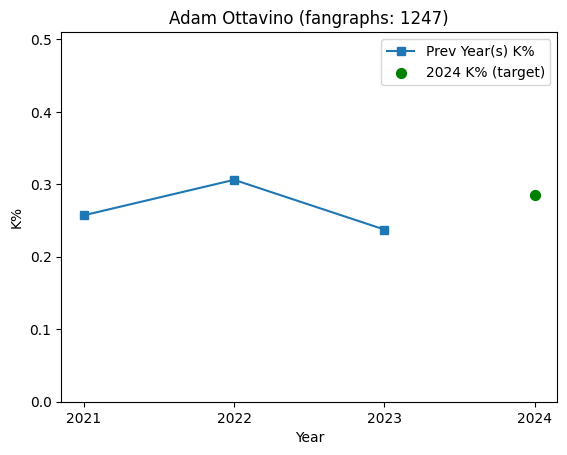

In [20]:
plot_player(1247, train, test, source="fangraphs")

In [21]:
lookup.get_id("Adam Ottavino")

loading player ids...


493603

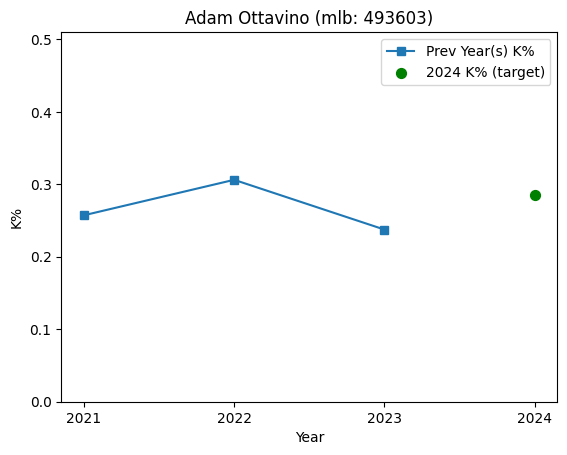

In [22]:
plot_player(lookup.get_id("Adam Ottavino"), train, test)

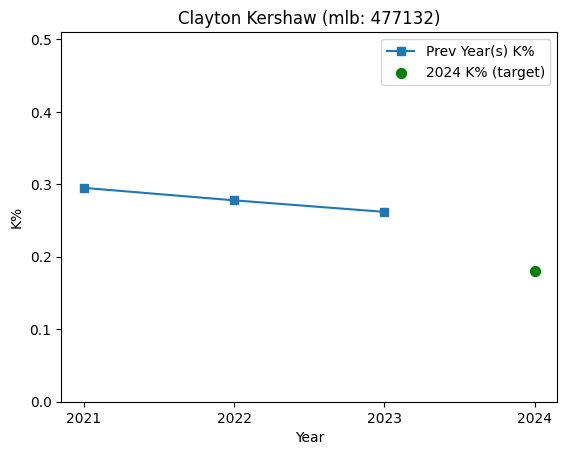

In [23]:
plot_player(lookup.get_id("Clayton Kershaw"), train, test)

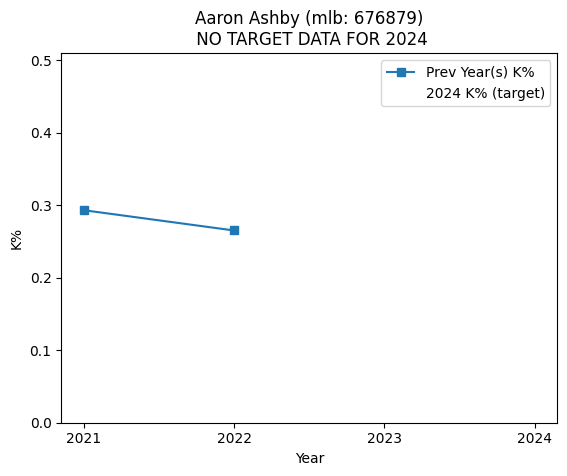

In [24]:
plot_player(lookup.get_id("Aaron Ashby"), train, test)

In [25]:
# players = sorted(train.Name.unique())

# for player in players:
#     plot_player(lookup.get_id(player), train, test)

In [26]:
lookup.mapping[lookup.mapping.Name == "Logan Allen"]

,MLBAMID,PlayerId,Name
383,671106,27589,Logan Allen
838,663531,18555,Logan Allen


In [27]:
df[df.Name == "Logan Allen"]

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%
383,671106,27589,Logan Allen,CLE,25,2024,432,0.182870
744,671106,27589,Logan Allen,CLE,24,2023,537,0.221601
1850,663531,18555,Logan Allen,CLE,24,2021,222,0.166667


In [28]:
# Handle duplicates!
lookup.get_id("Logan Allen")

ValueError: can only convert an array of size 1 to a Python scalar

In [32]:
sorted(df.Season.unique())

[2021, 2022, 2023, 2024]

In [1]:
from bullpen import data_utils

In [2]:
data_utils.PlayerLookup().datapath

'/Users/logan/Desktop/repos/mlb-pitcher-xK/data/player_ids.json'

In [3]:
lookup = data_utils.PlayerLookup()
lookup

PlayerLookup(datapath='/Users/logan/Desktop/repos/mlb-pitcher-xK/data/player_ids.json')

In [4]:
data_utils.PlayerLookup(
    datapath="/Users/logan/Desktop/repos/mlb-pitcher-xK/data/player_ids.json"
)

PlayerLookup(datapath='/Users/logan/Desktop/repos/mlb-pitcher-xK/data/player_ids.json')

In [5]:
lookup.mapping

loading player ids from /Users/logan/Desktop/repos/mlb-pitcher-xK/data/player_ids.json...


,MLBAMID,PlayerId,Name
0,695243,31757,Mason Miller
1,621242,14710,Edwin Díaz
2,518585,7048,Fernando Cruz
3,623352,14212,Josh Hader
4,663574,19926,Tony Santillan
...,...,...,...
858,592346,14663,Chi Chi González
859,642092,19826,Riley Smith
860,677976,23798,Randy Dobnak
861,433589,4020,Yusmeiro Petit


In [150]:
data_dir = here.parents[2].joinpath("data")
data_dir.exists()

True